In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pickle




In [2]:

# Read the dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Convert Date and Time columns to proper datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine Date and Time into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Convert relevant columns to numeric
cols_to_numeric = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Drop rows with NA values
df = df.dropna()


In [3]:
df.describe()
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [4]:
df.describe()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
count,2049280,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2049280
mean,2008-12-01 13:00:00.309181952,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,2008-12-02 00:59:44.397740544
min,2006-12-16 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2006-12-16 17:24:00
25%,2007-12-10 00:00:00,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-10 05:37:45
50%,2008-11-30 00:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-11-30 01:22:30
75%,2009-11-23 00:00:00,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-11-23 20:31:15
max,2010-11-26 00:00:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-11-26 21:02:00
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,NaN


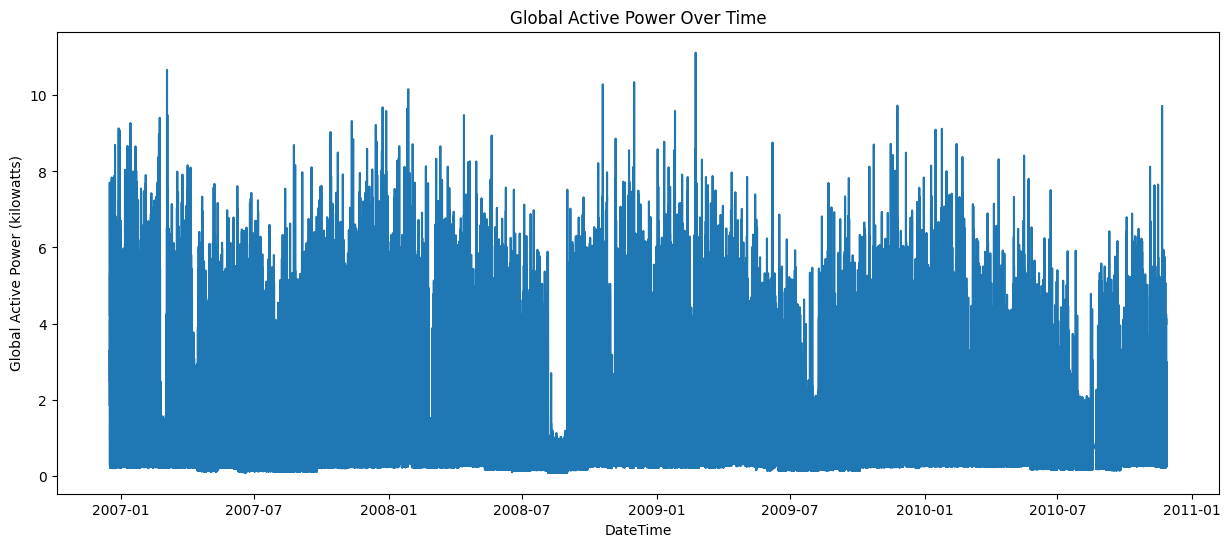

In [5]:
df_for_plots = df.copy()
# Time series plot for Global_active_power
plt.figure(figsize=(15, 6))
plt.plot(df_for_plots['DateTime'], df_for_plots['Global_active_power'])
plt.title('Global Active Power Over Time')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()


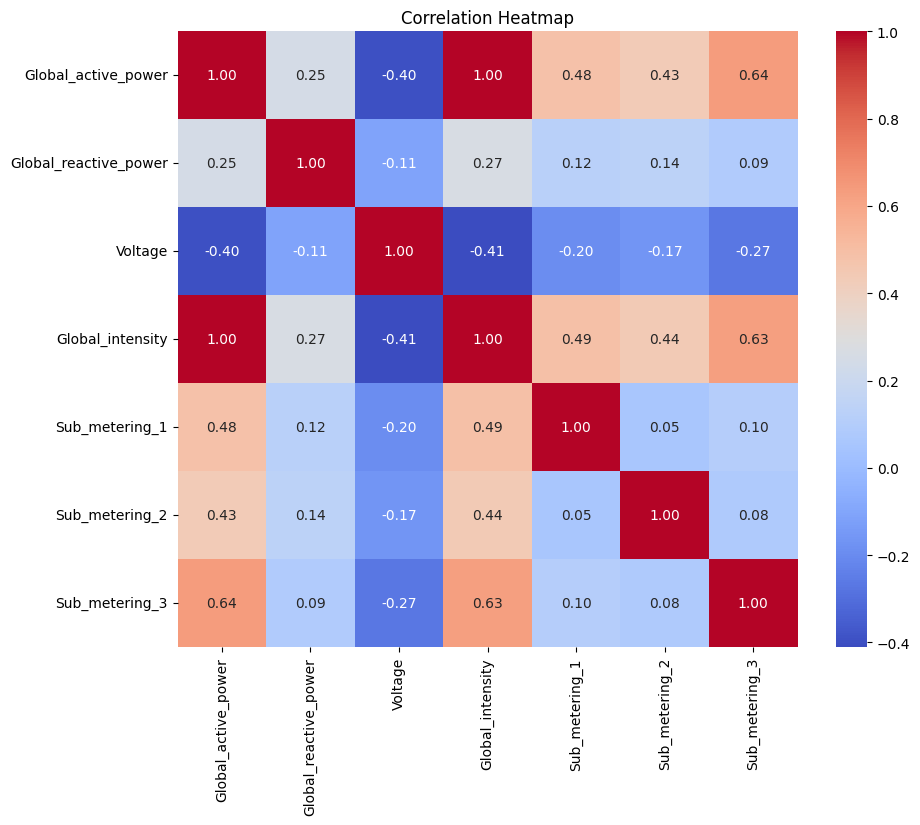

In [6]:

df_for_plots = df_for_plots.drop(['Date', 'Time', 'DateTime'], axis=1)
# numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(df_for_plots.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


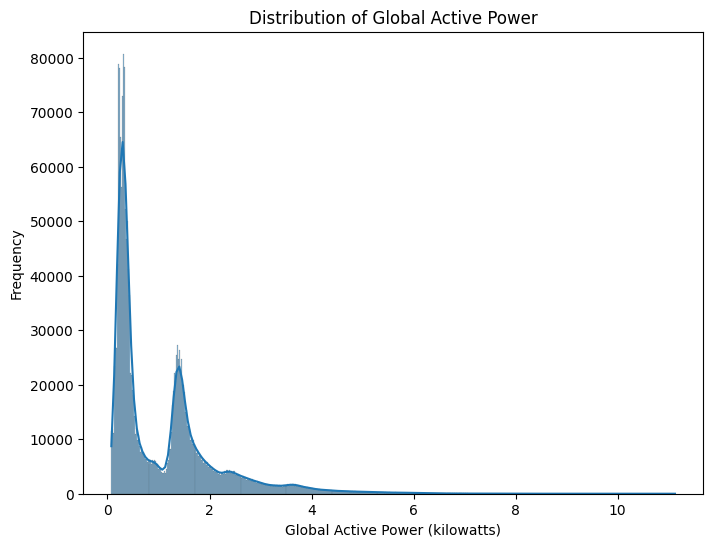

In [7]:
# Distribution plot for Global_active_power
plt.figure(figsize=(8, 6))
sns.histplot(df_for_plots['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.ylabel('Frequency')
plt.show()


In [8]:
df['Hour'] = df['DateTime'].dt.hour
df['Day_of_Week'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

df['Total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

df['Voltage_Global_intensity'] = df['Voltage'] * df['Global_intensity']

df['Global_active_power_lag1'] = df['Global_active_power'].shift(1)

df = df.drop(columns=['DateTime', 'Date', 'Time', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])


In [9]:

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform
df_scaled = scaler.fit_transform(df)

# Create a new DataFrame with the scaled data
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)


df_scaled.dropna(inplace=True)
df_scaled.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Hour,Day_of_Week,Month,Total_sub_metering,Voltage_Global_intensity,Global_active_power_lag1
1,4.037085,2.770406,-2.225274,4.133800,0.793638,1.006554,1.619991,0.631354,4.047438,2.955076
2,4.050326,3.320432,-2.330213,4.133800,0.793638,1.006554,1.619991,0.786839,4.040017,4.037084
3,4.063567,3.355917,-2.191324,4.133800,0.793638,1.006554,1.619991,0.709097,4.049839,4.050325
4,2.434881,3.586573,-1.592556,2.513782,0.793638,1.006554,1.619991,0.709097,2.481798,4.063566
5,2.296793,3.533345,-1.796260,2.333780,0.793638,1.006554,1.619991,0.786839,2.293470,2.434880


In [10]:
#take 20% of the data for testing
df_scaled = df_scaled.sample(frac=0.05, random_state=42)
df_scaled.shape

(102464, 10)

In [11]:
X = df_scaled.drop(columns='Global_active_power')
Y = df_scaled['Global_active_power']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [12]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'naive bayes': GaussianNB(),
    'MLPRegressor': MLPRegressor()
}

model_params = {
    'Linear Regression': {},
    'Random Forest': {'n_estimators': [10, 50, 100]},
    'Gradient Boosting': {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'AdaBoost': {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'Bagging': {'n_estimators': [10, 50, 100]},
    'naive bayes': {},
    'MLPRegressor': {'hidden_layer_sizes': [(100,), (50,), (25,)]}
}

best_models = {
    'Linear Regression': None,
    'Random Forest': None,
    'Gradient Boosting': None,
    'AdaBoost': None,
    'Bagging': None,
    'naive bayes': None,
    'MLPRegressor': None
}
best_test_scores = {
    'Linear Regression': {'MSE': None, 'R2': None},
    'Random Forest': {'MSE': None, 'R2': None},
    'Gradient Boosting': {'MSE': None, 'R2': None},
    'AdaBoost': {'MSE': None, 'R2': None},
    'Bagging': {'MSE': None, 'R2': None},
    'naive bayes': {'MSE': None, 'R2': None},
    'MLPRegressor': {'MSE': None, 'R2': None}
}


In [13]:

for model_name in models.keys():
    try:
        model = models[model_name]
        params = model_params[model_name]
        print(f'Training {model_name}', ' with params: ', params)
        print('-' * 50)
        grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, verbose=3)
        print('-' * 50)
        print(model_name)
        grid_search.fit(X_train, Y_train)
        print("best params for ", model_name, " are: ", grid_search.best_params_, " with score: ", grid_search.best_score_, "\n")
        best_models[model_name] = grid_search.best_estimator_
    except Exception as e:
        print(f'Error training {model_name}')
        print('\n')


Training Linear Regression  with params:  {}
--------------------------------------------------
--------------------------------------------------
Linear Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best params for  Linear Regression  are:  {}  with score:  0.9986772062499008 

Training Random Forest  with params:  {'n_estimators': [10, 50, 100]}
--------------------------------------------------
--------------------------------------------------
Random Forest
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best params for  Random Forest  are:  {'n_estimators': 100}  with score:  0.9992288605896811 

Training Gradient Boosting  with params:  {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]}
--------------------------------------------------
--------------------------------------------------
Gradient Boosting
Fitting 5 folds for each of 9 candidates, totalling 45 fits
best params for  Gradient Boosting  are:  {'learning_rate': 1, 'n_es

In [14]:
from pushbullet import Pushbullet
from dotenv import load_dotenv
import os
load_dotenv()

try:
    pb = Pushbullet(os.getenv("PB_API_KEY"))
    pb.push_note("Training Completed", "Training of models is completed")

except Exception as e:
    print("Error sending push notification: ", str(e))


{'active': True,
 'iden': 'ujyZs9sDhbosjvnGNw3FYG',
 'created': 1721388397.299934,
 'modified': 1721388397.299934,
 'type': 'note',
 'dismissed': False,
 'direction': 'self',
 'sender_iden': 'ujyZs9sDhbo',
 'sender_email': 'kedabaliyildirim@gmail.com',
 'sender_email_normalized': 'kedabaliyildirim@gmail.com',
 'sender_name': 'Kürşat Edabalı Yıldırım',
 'receiver_iden': 'ujyZs9sDhbo',
 'receiver_email': 'kedabaliyildirim@gmail.com',
 'receiver_email_normalized': 'kedabaliyildirim@gmail.com',
 'title': 'Training Completed',
 'body': 'Training of models is completed',
 'rate_limit': {'reset': '1721390955', 'limit': '16384', 'remaining': '16351'}}

In [22]:

#delete none types from dictionary
best_models = {k: v for k, v in best_models.items() if v is not None}

for model_name in best_models.keys():
    model = best_models[model_name]
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    best_test_scores[model_name]['MSE'] = mse
    best_test_scores[model_name]['R2'] = r2

best_test_scores

Linear Regression
Random Forest
Gradient Boosting
AdaBoost
Bagging
MLPRegressor


{'Linear Regression': {'MSE': np.float64(0.0013421638673391482),
  'R2': 0.9986811318869814},
 'Random Forest': {'MSE': np.float64(0.000759513215787635),
  'R2': 0.999253669551018},
 'Gradient Boosting': {'MSE': np.float64(0.000953350503777614),
  'R2': 0.999063196670273},
 'AdaBoost': {'MSE': np.float64(0.009219161328059342),
  'R2': 0.990940854391754},
 'Bagging': {'MSE': np.float64(0.0007614126303473695),
  'R2': 0.9992518031043366},
 'naive bayes': {'MSE': None, 'R2': None},
 'MLPRegressor': {'MSE': np.float64(0.0010990961704034471),
  'R2': 0.9989199806912104}}

In [26]:
best_model = None
best_score = 0
best_test_scores = {k: v for k, v in best_test_scores.items() if v['R2'] is not None}
for model_name in best_test_scores.keys():
    score = best_test_scores[model_name]['R2']
    if score > best_score:
        best_score = score
        best_model = model_name

print(f'Best Model: {best_model}')
print(f'R2 Score: {best_score}')


Best Model: Random Forest
R2 Score: 0.999253669551018


In [28]:

# Save the best model
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_models[best_model], file)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
